In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
# For wrangling and numerical process
import pandas as pd
import numpy as np

# For scheduling and stuff
from datetime import timedelta, datetime
from matplotlib import pyplot as plt

# For SQL importing
from sqlalchemy import create_engine, types

# Basic needs
import os
import requests
import shutil
import time

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

# 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')




In [4]:

import time
import datetime
import math
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
from tqdm import tqdm_notebook as tqdm
import sys
import warnings

from scipy.special import logit, expit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# importa data

In [714]:
data= pd.read_csv('final_modelling.csv')

In [715]:
data['de_date_joined']= pd.to_datetime(data['de_date_joined'])
data['appl_month']= pd.to_datetime(data['appl_month'])

In [716]:
data['fb_relation_upd']= data['fb_relation_upd'].astype(str)
data['ph_other_device_info_upd']= data['ph_other_device_info_upd'].astype(str)

In [717]:
data= data.drop(columns=['data_type'])

# data definitions

In [718]:
col_id='index'
col_time='de_date_joined'
col_month='appl_month'
col_target='flag_bad'
col_base='flag_bad_obs'

In [1040]:
data[[a for a in data.columns if 'WOE' not in a]].shape

(41022, 814)

## Quick EDA

In [719]:
# Information about data type, missing values, unique sample
def data_information(df):
    data_info = pd.DataFrame({'Data_Type':df.dtypes,
                              'N_Missing':df.isnull().sum(),
                              '%_Missing':["{0:.0%}".format(x) for x in df.isnull().sum()/len(df)], 
                              'N_Unique':df.nunique().values,
                              'Sample':list(zip(df.sample(5).values[0], df.sample(5).values[4]))})
    return data_info

def cat_or_num(df):
    cat_cols = df.select_dtypes(["object", "category"]).columns.tolist()
    num_but_cat = [col for col in df.select_dtypes(["float", "integer"]).columns if df[col].nunique() <= 15]
    cat_but_many = [col for col in df.select_dtypes(["object", "category"]).columns if df[col].nunique() > 15]
    
    cat_cols = [col for col in cat_cols if col not in cat_but_many]

    num_cols = df.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'cat_but_many: {len(cat_but_many)}')

    return cat_cols, num_cols, num_but_cat, cat_but_many
    
def histogram(df, columns):
    
    n_rows = math.ceil(len(columns)/3)
    col_name = columns
    label = 'TARGET'
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15,3*n_rows))

    for name, ax in zip(col_name, axes.flatten()):

        sns.distplot(df[df[label]==0][name], ax=ax, label='non-default', color='#5DBAE8')
        sns.distplot(df[df[label]==1][name], ax=ax, label='default', color='#D71B3B')
        ax.legend(prop={'size': 12})
        ax.set_title('Histogram ' + name)  
        
    plt.tight_layout()
    plt.show()

In [720]:
cols_non_pred= ['index','appl_month','de_date_joined','flag_bad','flag_bad_obs','gm_scoring_model_v1','fb_relation','data_type','bin'
               
               'id_credit','WEIGHT'
               ]
cols_pred= [a for a in data.columns if a not in  cols_non_pred]

In [721]:
# cols=cols_pred[1]
list_single=[]
for cols in tqdm(cols_pred, desc='Processing columns'):
    if len(data[cols].value_counts().index.unique())<=1:
        list_single.append(cols)
    else:
        pass
print(f'{len(list_single)} predictors with less than 1 unique value ')

cols_pred = [lst for lst in cols_pred if lst not in list_single]
print(f" drop columns {list_single} due to single unique value")

Processing columns:   0%|          | 0/803 [00:00<?, ?it/s]

1 predictors with less than 1 unique value 
 drop columns ['de_accomodation_type'] due to single unique value


In [722]:

cat_cols, num_cols, num_but_cat, cat_but_many = cat_or_num(data[cols_pred])
# cat_cols, num_cols, num_but_cat, cat_but_many = cat_or_num(data[cols_shortlist])

Observations: 41022
Variables: 802
cat_cols: 2
num_cols: 559
num_but_cat: 241
cat_but_many: 0


### check hit rate

In [723]:
print('== predictor with lowest HITRATE : ')
display((data[cols_pred].notnull().sum()/data.shape[0]*100).round(1).sort_values().head(10).reset_index().rename(columns = {'index':'predictor',0:'hit_rate'}))
print('== predictor with HIGHEST HITRATE : ')
display((data[cols_pred].notnull().sum()/data.shape[0]*100).round(1).sort_values().tail(10).reset_index().rename(columns = {'index':'predictor',0:'hit_rate'}))

== predictor with lowest HITRATE : 


,predictor,hit_rate
0,ratio_Social Media_judol_apps,0.2
1,ratio_Shopping_judol_apps,0.2
2,ratio_competitor_flag_judol_apps,0.2
3,ratio_Entertainment_judol_apps,0.2
4,ratio_Productivity_judol_apps,0.2
5,ratio_pinjaman_judol_apps,0.2
6,ratio_Photography_judol_apps,0.2
7,ratio_Utility_judol_apps,0.2
8,ratio_Communication_judol_apps,0.2
9,ratio_Games_judol_apps,0.2


== predictor with HIGHEST HITRATE : 


,predictor,hit_rate
0,de_marital_status,100.0
1,ph_other_device_info_upd,100.0
2,ph_total_contacts,100.0
3,r_salary_cnt_children,100.0
4,id_credit,100.0
5,DAY,100.0
6,MONTH,100.0
7,fb_relation_upd,100.0
8,de_children,100.0
9,de_age,100.0


### check data type and information 

In [724]:
data_information(data)

,Data_Type,N_Missing,%_Missing,N_Unique,Sample
index,int64,0,0%,41022,"(26329, 20838)"
de_age,int64,0,0%,50,"(20, 39)"
de_date_joined,datetime64[ns],0,0%,192,"(2018-05-05 00:00:00, 2018-04-13 00:00:00)"
de_num_friends,int64,0,0%,4531,"(182, 588)"
de_monthly_salary,int64,0,0%,40,"(3000000, 5000000)"
...,...,...,...,...,...
sum_pinjaman_competitor_flag,float64,913,2%,27,"(0.0, 0.0)"
sum_pinjaman_fintech,float64,913,2%,25,"(0.0, 0.0)"
sum_pinjaman_judol_apps,float64,913,2%,23,"(0.0, 0.0)"
gm_scoring_model_v1,float64,0,0%,3057,"(0.4160559018182876, 0.0438708361280299)"


# feature selection 

on this approach severall method use
-  CHeck feature Importance
- Shap importance

make sure the predictor give benefit to the final output of model


In [ ]:
cols=cols_pred[2]
cols

## automatic Grouping

In [725]:
def calculate_woe(df, predictor, target):
    # Create bins
    if pd.api.types.is_numeric_dtype(df[predictor]):
        # Numeric predictor: Create bins using qcut
        df['bin'] =  pd.qcut(df[predictor].fillna(-999), q=5, duplicates='drop')
    else:
        # Categorical predictor: Use the unique values as bins
        df['bin'] = df[predictor]
#     df['bin'] = pd.qcut(df[predictor], q=5, duplicates='drop')
    
    # Calculate WOE for each bin
    bins = df.groupby('bin').agg({target: ['sum', 'count']})
    bins.columns = ['events', 'total']
    bins['non_events'] = bins['total'] - bins['events']
    bins['event_rate'] = bins['events'] / bins['total']
    bins['non_event_rate'] = bins['non_events'] / bins['total']
    
    # Avoid division by zero
    bins.replace(0, np.nan, inplace=True)
    
    bins['woe'] = np.log(bins['event_rate'] / bins['non_event_rate'])
    bins['pred']=predictor
    
    return bins[['woe','pred']]
def apply_woe(df, predictor, bins):
    if pd.api.types.is_numeric_dtype(df[predictor]):
        # Numeric predictor: Create bins using qcut
        df['bin'] =  pd.qcut(df[predictor].fillna(-999), q=5, duplicates='drop')
    else:
        # Categorical predictor: Use the unique values as bins
        df['bin'] = df[predictor]
    df = df.merge(bins, left_on='bin', right_index=True, how='left')
    df[predictor + '_WOE'] = df['woe']
    return df[predictor + '_WOE']

In [726]:
list_woe=[]
for cols in tqdm(cols_pred, desc='Processing columns'):
# Calculate WOE for each predictor
    woe_pred1 = calculate_woe(data, cols, col_target)
    list_woe.append(apply_woe(data, cols, woe_pred1))



Processing columns:   0%|          | 0/802 [00:00<?, ?it/s]

In [ ]:
# list_woe

In [727]:
data=pd.concat([ data, pd.concat(list_woe,axis=1)          
          ],axis=1)
# data= pd.concat(data,pd.concat(list_woe,axis=1),axis=1)
for sub in list_woe:
    print(f'{sub.name} is added to dataframe set')
cols_woe= [a.name for a in list_woe]

de_age_WOE is added to dataframe set
de_num_friends_WOE is added to dataframe set
de_monthly_salary_WOE is added to dataframe set
de_employment_type_WOE is added to dataframe set
de_employment_duration_WOE is added to dataframe set
de_education_WOE is added to dataframe set
de_marital_status_WOE is added to dataframe set
de_children_WOE is added to dataframe set
ph_total_contacts_WOE is added to dataframe set
fb_latest_update_WOE is added to dataframe set
r_salary_cnt_children_WOE is added to dataframe set
ph_other_device_info_upd_WOE is added to dataframe set
percent_incoming_nighttime_WOE is added to dataframe set
percent_outgoing_daytime_WOE is added to dataframe set
duration_incoming_daytime_WOE is added to dataframe set
duration_outgoing_daytime_WOE is added to dataframe set
percent_incoming_daytime_WOE is added to dataframe set
percent_other_calls_WOE is added to dataframe set
duration_outgoing_nighttime_WOE is added to dataframe set
percent_outgoing_nighttime_WOE is added to dat

## Feature importance  & Shap importance

In [728]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # Or any other metric suitable for your problem

In [729]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # Or any other metric suitable for your problem


X_train, X_test, y_train, y_test = train_test_split(data[cols_woe], data[col_target], test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set model parameters
params = {
    'objective': 'binary',  # or 'regression' or other objective based on your problem
    'metric': 'binary_logloss',  # or another metric based on your problem
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
model = lgb.train(params, train_data, valid_sets=[test_data], early_stopping_rounds=100)
import matplotlib.pyplot as plt

# Get feature importance
importance = model.feature_importance()
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4282, number of negative: 28535
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.704543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 32817, number of used features: 682
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130481 -> initscore=-1.896711
[LightGBM] [Info] Start training from score -1.896711
[1]	valid_0's binary_logloss: 0.375201
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.37129
[3]	valid_0's binary_logloss: 0.367853
[4]	valid_0's binary_logloss: 0.364916
[5]	valid_0's binary_logloss: 0.362517
[6]	valid_0's binary_lo

visualize top 20 predictor based on feature importance

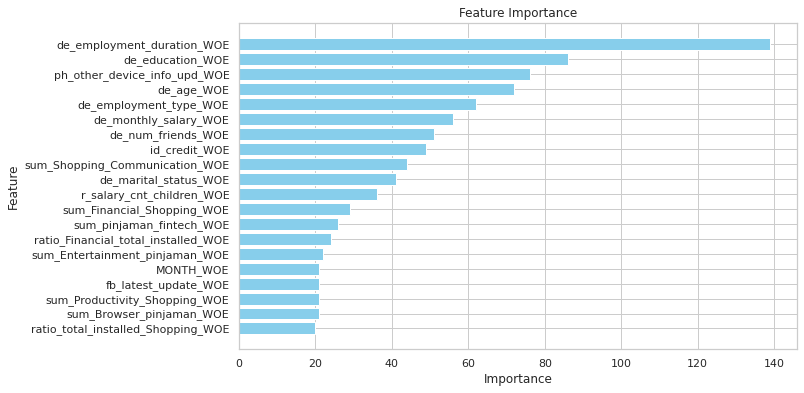

In [730]:
importance_df=feature_importance_df.head(20)
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Optional: Invert y-axis to have the most important feature on top
plt.show()

In [1032]:
def check_gini_performance(cols_woe,data,col_target,top):
    check_gini_each=[]
    for cols in tqdm(cols_woe, desc='Processing columns'):
        gini_check= 2*roc_auc_score(
        data[col_target],
            data[cols]
        )-1
        check_gini_each.append(abs(gini_check))
    df_gini= pd.DataFrame({

        'pred':cols_woe,
        'gini':check_gini_each
    }).sort_values('gini',ascending=False)
    list_zero= list(df_gini[df_gini['gini']==0]['pred'])
    df_gini= df_gini.head(top).sort_values('gini',ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(df_gini['pred'], df_gini['gini'], color='skyblue')
    plt.xlabel('Gini Score')
    plt.ylabel('Predictor')
    plt.title('Gini Scores by Predictor')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    print(f"{list_zero} have 0% Univariate Gini --> not predictive")

Processing columns:   0%|          | 0/86 [00:00<?, ?it/s]

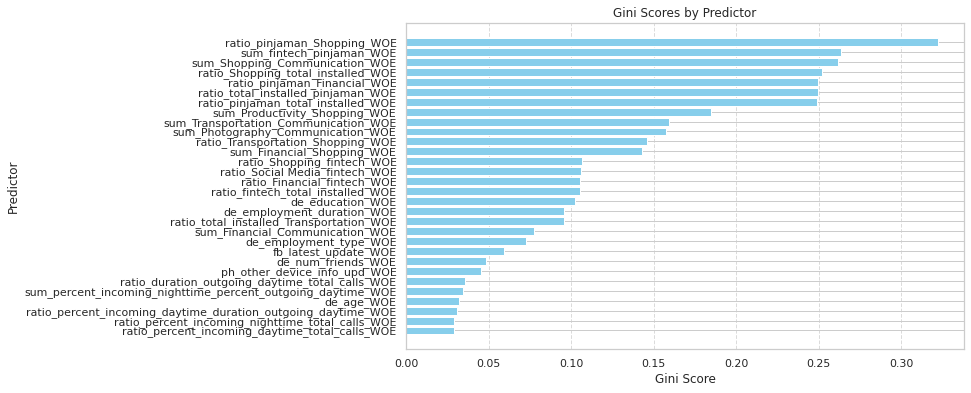

[] have 0% Univariate Gini --> not predictive


In [1033]:
check_gini_performance(cols_woe,data,col_target,30)

In [ ]:
# feature_importance_df[feature_importance_df['Importance']>8]

## shortlisted feature

In [733]:
cols_shortlist= ['de_employment_duration',
 'de_age',
 'fb_latest_update',
 'ph_total_contacts',
 'de_num_friends',
 'ratio_percent_incoming_nighttime_percent_outgoing_daytime',
 'ratio_pinjaman_Financial',
 'ratio_pinjaman_Shopping',
 'r_salary_cnt_children',
 'sum_Financial_Communication',
 'sum_Financial_Shopping',
 'sum_fintech_pinjaman',
 'percent_outgoing_nighttime',
 'ratio_duration_outgoing_daytime_total_calls',
 'de_monthly_salary',
 'ratio_percent_incoming_nighttime_duration_incoming_nighttime',
 'sum_percent_incoming_nighttime_percent_incoming_daytime',
 'ratio_percent_incoming_daytime_duration_outgoing_daytime',
 'sum_Shopping_Communication',
 'ratio_duration_incoming_daytime_percent_outgoing_daytime',
 'ratio_percent_other_calls_percent_outgoing_nighttime',
 'ratio_duration_incoming_daytime_duration_outgoing_nighttime',
 'ratio_percent_incoming_nighttime_duration_incoming_daytime',
 'ratio_pinjaman_total_installed',
 'ratio_Entertainment_Browser',
 'ratio_Shopping_total_installed',
 'sum_percent_outgoing_daytime_percent_incoming_daytime',
 'sum_percent_other_calls_duration_incoming_nighttime',
 'sum_percent_incoming_nighttime_percent_outgoing_nighttime',
 'ratio_Financial_fintech',
 'ratio_total_calls_percent_outgoing_daytime',
 'ratio_percent_incoming_daytime_duration_outgoing_nighttime',
 'ratio_percent_other_calls_duration_incoming_daytime',
 'ratio_percent_outgoing_nighttime_duration_incoming_daytime',
 'ratio_duration_incoming_daytime_percent_incoming_daytime',
 'ratio_Shopping_fintech',
 'sum_percent_other_calls_total_calls',
 'percent_incoming_daytime',
 'sum_duration_outgoing_nighttime_total_calls',
 'ratio_percent_outgoing_nighttime_duration_incoming_nighttime',
 'ratio_percent_outgoing_nighttime_percent_incoming_nighttime',
 'sum_percent_incoming_nighttime_percent_outgoing_daytime',
 'sum_percent_incoming_daytime_duration_outgoing_nighttime',
 'ratio_percent_other_calls_duration_incoming_nighttime',
 'sum_percent_incoming_nighttime_percent_other_calls',
 'sum_Productivity_Shopping',
 'ratio_duration_outgoing_nighttime_percent_incoming_daytime',
 'ratio_percent_incoming_daytime_total_calls',
 'ratio_percent_incoming_daytime_percent_other_calls',
 'ratio_percent_incoming_nighttime_duration_outgoing_nighttime',
 'ratio_duration_outgoing_daytime_percent_incoming_nighttime',
 'ratio_Social Media_fintech',
 'ratio_duration_incoming_daytime_duration_outgoing_daytime',
 'sum_duration_outgoing_nighttime_duration_incoming_nighttime',
 'sum_duration_outgoing_daytime_duration_incoming_nighttime',
 'ratio_total_installed_pinjaman',
 'sum_percent_outgoing_daytime_percent_other_calls',
 'sum_Productivity_Games',
 'ratio_total_calls_percent_incoming_nighttime',
 'ratio_percent_other_calls_percent_incoming_nighttime',
 'ratio_percent_outgoing_daytime_duration_incoming_daytime',
 'ratio_duration_outgoing_daytime_percent_outgoing_daytime',
 'ratio_duration_outgoing_nighttime_total_calls',
 'ratio_duration_incoming_daytime_total_calls',
 'ratio_percent_outgoing_nighttime_percent_incoming_daytime',
 'percent_incoming_nighttime',
 'sum_Transportation_Communication',
 'sum_duration_incoming_daytime_total_calls',
 'ratio_percent_outgoing_daytime_percent_incoming_daytime',
 'sum_Productivity_Financial',
 'ratio_total_installed_Transportation',
 'ratio_duration_outgoing_nighttime_percent_incoming_nighttime',
 'ratio_percent_outgoing_daytime_duration_incoming_nighttime',
 'ratio_percent_incoming_nighttime_total_calls',
 'ratio_Transportation_Shopping',
 'ratio_percent_incoming_nighttime_percent_other_calls',
 'ratio_fintech_total_installed',
 'sum_percent_outgoing_nighttime_total_calls',
 'ratio_percent_incoming_daytime_percent_incoming_nighttime',
 'de_education',
 'de_employment_type',
 'de_children',
 'de_marital_status',
 'sum_Photography_Communication',
 'ph_other_device_info_upd',
 'fb_relation_upd']

# apply proper Grouping

still on sub set final predictors. around **40 Predictors which later will be trained ** 

on the last run notebook , only trained and apply grouping for the final predictor of model

In [734]:

# cat_cols, num_cols, num_but_cat, cat_but_many = cat_or_num(data[cols_pred])
cat_cols, num_cols, num_but_cat, cat_but_many = cat_or_num(data[cols_shortlist])

Observations: 41022
Variables: 86
cat_cols: 2
num_cols: 79
num_but_cat: 5
cat_but_many: 0


In [735]:
from """===library_modelling===""" import Grouping

cols_togroup_num = num_cols + num_but_cat
cols_togroup_cat = cat_cols


In [736]:
from """===library_modelling===""" import Grouping

grouping = Grouping(columns = cols_togroup_num,
                    cat_columns = cols_togroup_cat,
                    group_count=5, 
                    min_samples=100, 
                    min_samples_cat=100,
                    woe_smooth_coef=0.001) 
g_filename = 'manual_grouping_upd.json'
# g_filename = 'a.json'
grouping.load(g_filename)

In [737]:
data_woe = grouping.transform(data, transform_to='woe', progress_bar=True)

  0%|          | 0/86 [00:00<?, ?cols/s]

In [738]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(woe_columns_to_replace, axis='columns')
data = data.join(data_woe)

del data_woe
gc.collect()

print('Added WOE variables. Number of columns:',data.shape[1])
cols_woe = [s + '_WOE' for s in cols_shortlist]

Column de_employment_duration_WOE dropped as it already existed in the data set.
Column de_age_WOE dropped as it already existed in the data set.
Column fb_latest_update_WOE dropped as it already existed in the data set.
Column ph_total_contacts_WOE dropped as it already existed in the data set.
Column de_num_friends_WOE dropped as it already existed in the data set.
Column ratio_percent_incoming_nighttime_percent_outgoing_daytime_WOE dropped as it already existed in the data set.
Column ratio_pinjaman_Financial_WOE dropped as it already existed in the data set.
Column ratio_pinjaman_Shopping_WOE dropped as it already existed in the data set.
Column r_salary_cnt_children_WOE dropped as it already existed in the data set.
Column sum_Financial_Communication_WOE dropped as it already existed in the data set.
Column sum_Financial_Shopping_WOE dropped as it already existed in the data set.
Column sum_fintech_pinjaman_WOE dropped as it already existed in the data set.
Column percent_outgoing

Added WOE variables. Number of columns: 1614


## grouping stabiility

In [859]:

def plotting_grouping(cols,data,col_target,col_id):
    agg= pd.concat([data.groupby(['appl_month',cols])[col_target].mean(),
    data.groupby(['appl_month',cols])[col_id].count()/data.groupby(['appl_month'])[col_id].count()
                   ],axis=1)
    agg.columns = ['bad_rate', 'share']
    list_gini_calc=[]
    for month in list(data['appl_month'].unique()):

        gini_= abs(2*roc_auc_score(
        data[data['appl_month']==month][col_target],
            data[data['appl_month']==month][cols]
        )-1)
        list_gini_calc.append(gini_)

    gini_monthly= pd.DataFrame({
        'appl_month':list(data['appl_month'].unique()),
        'gini_month':  list_gini_calc}).set_index('appl_month')

    agg_reset = agg.reset_index()
    fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
    fig.patch.set_facecolor('white')
    light_blue = '#e0f7fa'  # Subtle light blue color code
    for ax in axs:
        ax.set_facecolor(light_blue)

    # Set Seaborn style
    sns.set(style="whitegrid")
    palette = sns.color_palette("husl", n_colors=len(agg_reset[cols].unique()))

    # Left Plot: Monthly Bad Rate
    sns.lineplot(data=agg_reset, x='appl_month', y='bad_rate', hue=cols, marker='o', ax=axs[0],palette=palette)
    axs[0].set_title(f'Monthly Bad Rate {cols}',fontsize=14)
    axs[0].set_xlabel('Month',fontsize=13)
    axs[0].set_ylabel('Bad Rate',fontsize=13)
    axs[0].tick_params(axis='x', rotation=45,labelsize=12)  # Rotate x-axis labels
    try:
        legends=[f'NAN' if str(a)=='nan' else f'<{round(a,1)}' for a in list(data.groupby(cols)[cols.replace('_WOE','')].agg('max'))]
    except:
        legends=list(data.groupby([cols]).agg({cols.replace('_WOE',''):'max'})[cols.replace('_WOE','')])
    axs[0].legend(legends,title='Legend', bbox_to_anchor=(-0.15, 1.05), loc='upper left',)

    # Middle Plot: Monthly Share
    sns.lineplot(data=agg_reset, x='appl_month', y='share', hue=cols, marker='o', ax=axs[1],palette=palette)
    axs[1].set_title(f'Monthly Share {cols}',fontsize=14 )
    axs[1].set_xlabel('Month',fontsize=14)
    axs[1].set_ylabel('Share',fontsize=14)
    axs[1].tick_params(axis='x', rotation=45,labelsize=12)  # Rotate x-axis labels
    axs[1].legend_.remove()  # Remove legend from the middle plot
    axs[1].set_ylim(-0.05, 1.1)  # Set y-axis limit for Gini plot
    axs[1].yaxis.set_label_position('right')

    # Right Plot: Gini by Month
    sns.lineplot(data=gini_monthly.reset_index(), x='appl_month', y='gini_month', marker='o', color='r', ax=axs[2],palette=palette)
    axs[2].set_title(f'Gini by Month {cols}',fontsize=14)
    axs[2].set_xlabel('Month',fontsize=14)
    axs[2].set_ylabel('Gini',fontsize=14)
    axs[2].set_ylim(0, 0.42)  # Set y-axis limit for Gini plot
    axs[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axs[1].yaxis.set_label_position('right')
    # axs[2].legend_.remove()  # Remove legend from the right plot


    plt.tight_layout()
    plt.show()

In [930]:



def plotting_grouping_all(data,col_id,col_target):
    fig, ax1 = plt.subplots(figsize=(8,5))
    agg_woe= data.groupby(cols).agg({
        col_id:'count',
        cols.replace('_WOE',''):['min','max'],
        col_target:'mean'

    }).sort_index().reset_index()
    agg_woe.columns=['woe','count','min','max','bad_rate']
    if agg_woe['max'].dtypes != 'object':
        agg_woe['max']= agg_woe['max'].round(1)
        agg_woe['min']= agg_woe['min'].round(1)
        agg_woe['range']=agg_woe.apply(lambda row: f"{row['min']} - {row['max']}", axis=1)
    else:
        agg_woe['max']= agg_woe['max']
        agg_woe['min']= agg_woe['min']
        agg_woe['range']=agg_woe.apply(lambda row: f"[{row['min']}, {row['max']}]", axis=1)
        
    agg_woe= agg_woe.set_index('range')
    # Plot the bar chart on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Range')
    ax1.set_ylabel('Count', color=color)
    ax1.bar(agg_woe.index, agg_woe['count'], color=color, alpha=0.6, label='Count')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(len(agg_woe.index)))  # Set x-ticks
    ax1.set_xticklabels(agg_woe.index, rotation=45)  # Set x-tick labels and rotate them

    # Create a secondary y-axis and plot the line plot for WOE
    ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('WOE', color=color)
    ax2.plot(agg_woe.index, agg_woe['woe'], color=color, marker='o', label='WOE')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add grid, title, and legend
    ax1.grid(True)
    fig.suptitle(f'WOE CHART for {cols}', fontsize=16)
    fig.tight_layout()  # Adjust layout to fit labels

    # Show the plot
    plt.show()

    # Calculate IV
    agg_woe['good'] = 1 - agg_woe['bad_rate']
    agg_woe['bad'] = agg_woe['bad_rate']
    agg_woe['good_dist'] = agg_woe['good'] / agg_woe['good'].sum()
    agg_woe['bad_dist'] = agg_woe['bad'] / agg_woe['bad'].sum()

    agg_woe['iv_contrib'] = (agg_woe['good_dist'] - agg_woe['bad_dist']) * agg_woe['woe']
    iv = agg_woe['iv_contrib'].sum()
    agg_woe['iv']=iv
    agg_woe['pred']=cols
    agg_woe=agg_woe[['woe','count','min','max','bad_rate','iv','pred']]
    display(agg_woe)
    print(f' Informative values for the {cols} : {iv}')
    return 

In [890]:
cols_grouping=['ratio_pinjaman_Shopping_WOE',
 'sum_Financial_Shopping_WOE',
 'de_employment_type_WOE',
 'ratio_Financial_fintech_WOE',
 'sum_Photography_Communication_WOE',
 'fb_latest_update_WOE',
 'sum_Productivity_Financial_WOE',
 'de_num_friends_WOE',
 'de_education_WOE',
 'r_salary_cnt_children_WOE',
 'ph_other_device_info_upd_WOE',
 'de_employment_duration_WOE']

ratio_pinjaman_Shopping_WOE


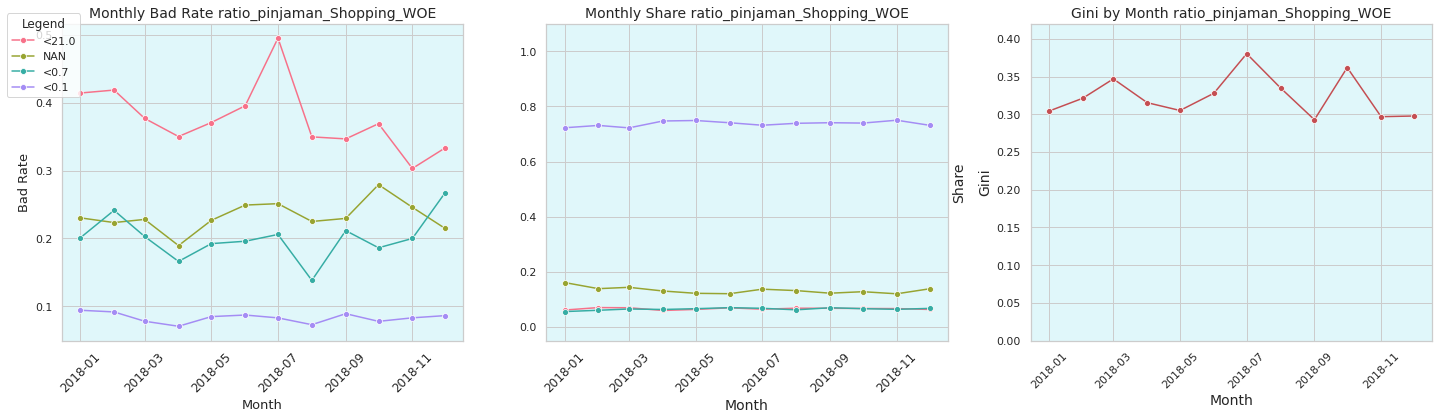

sum_Financial_Shopping_WOE


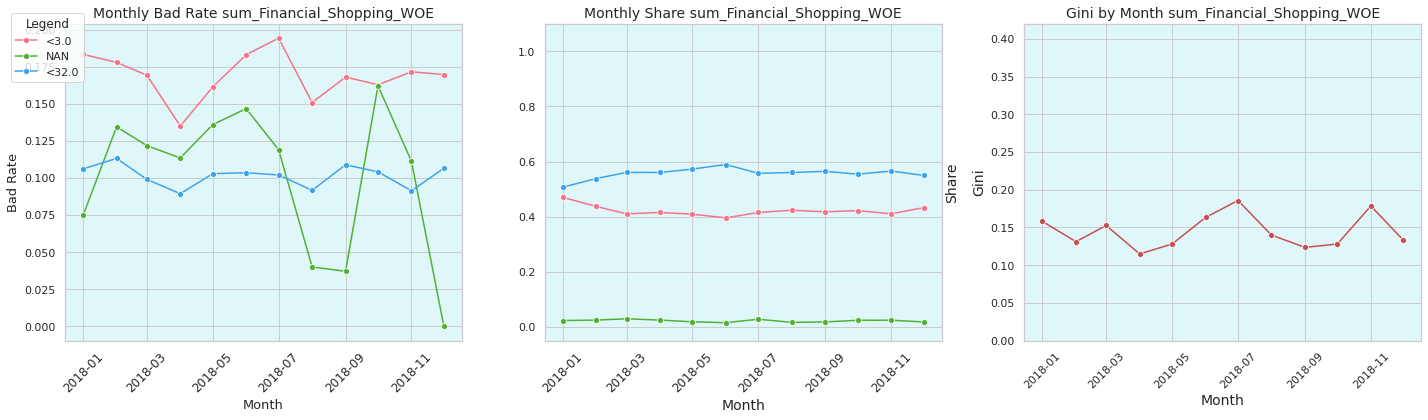

de_employment_type_WOE


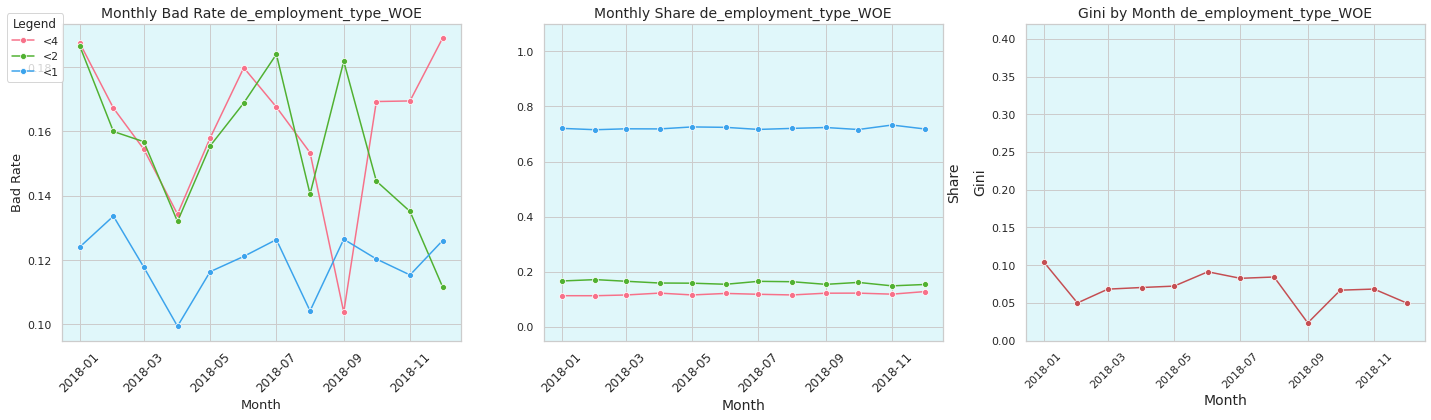

ratio_Financial_fintech_WOE


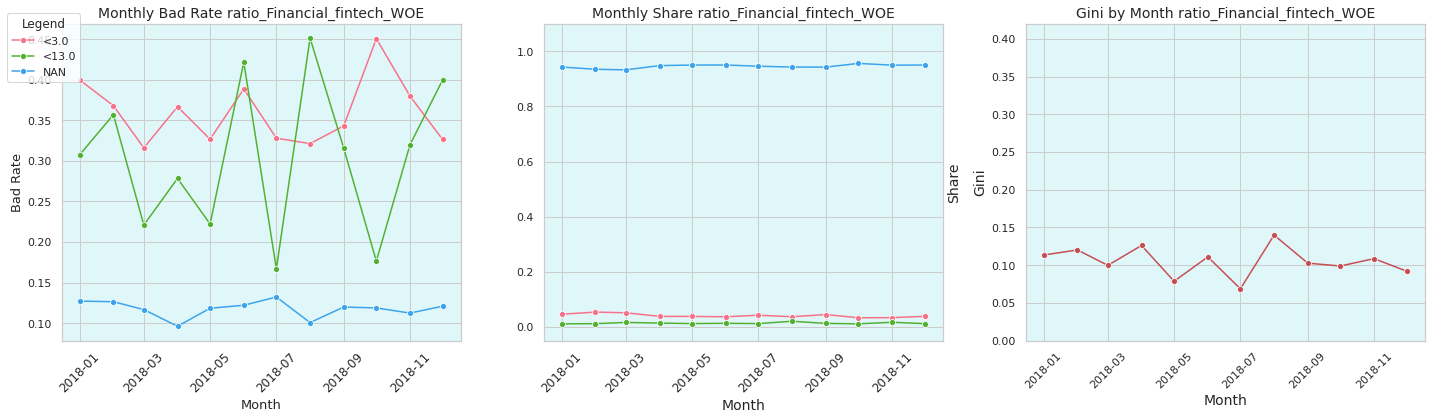

sum_Photography_Communication_WOE


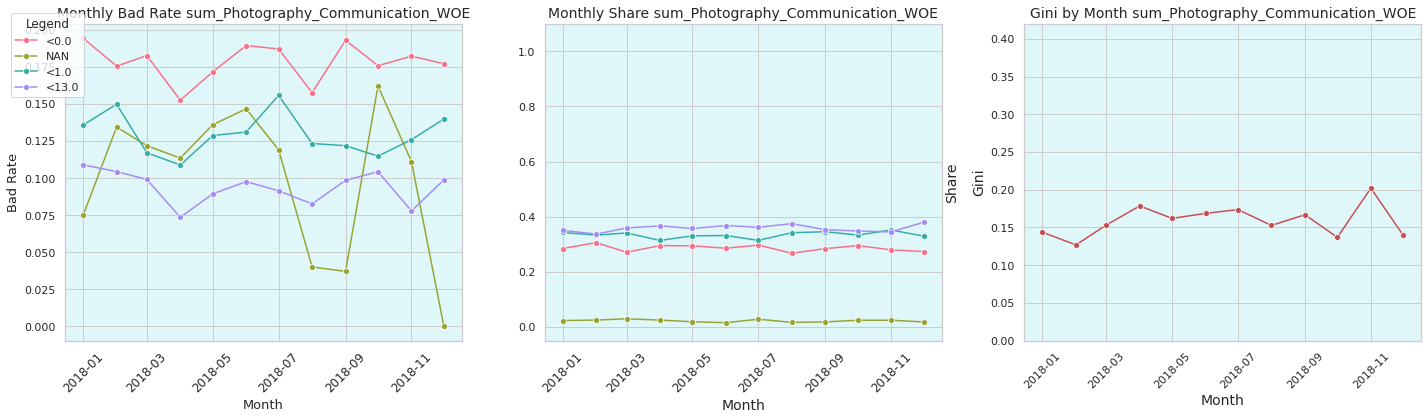

fb_latest_update_WOE


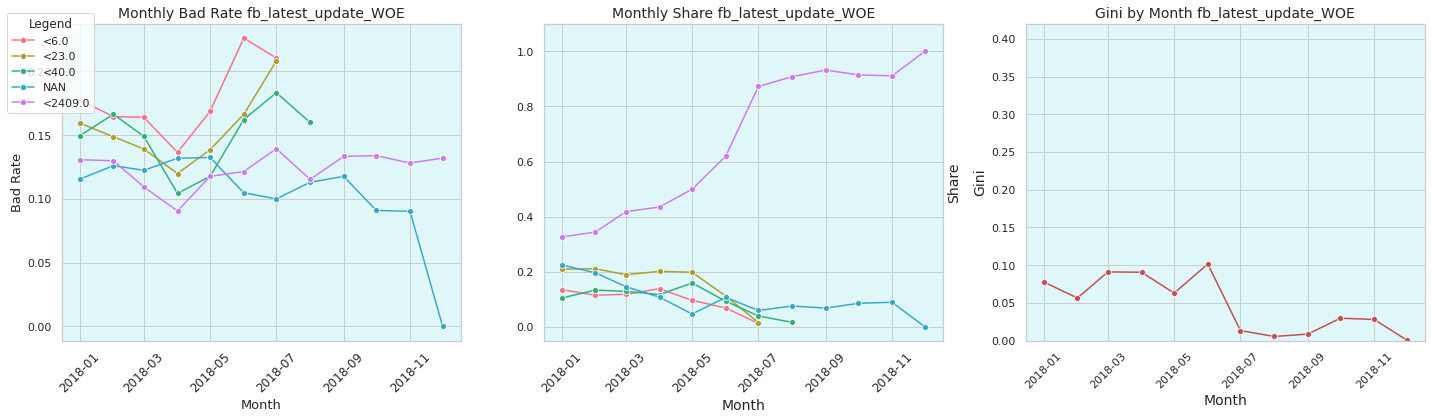

sum_Productivity_Financial_WOE


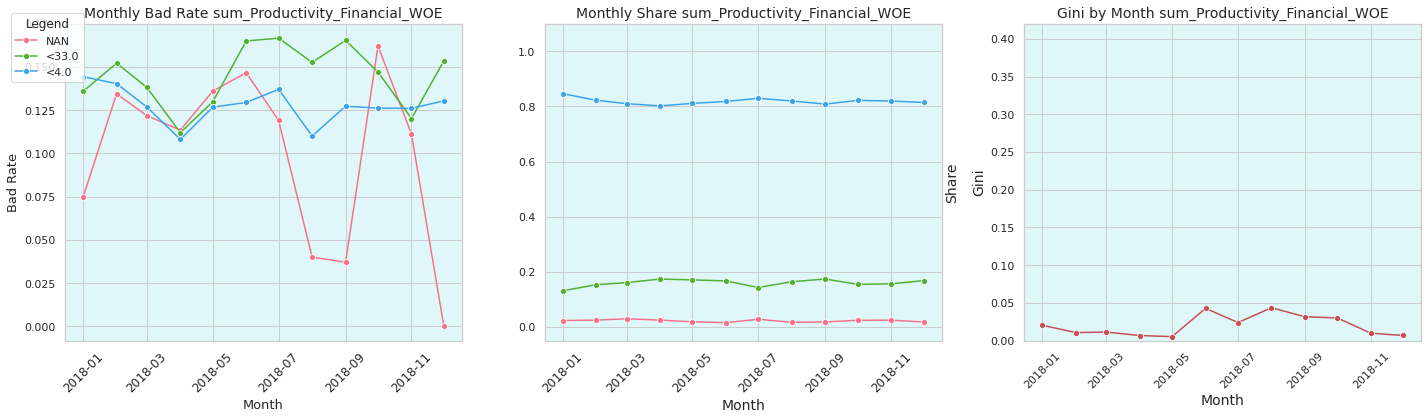

de_num_friends_WOE


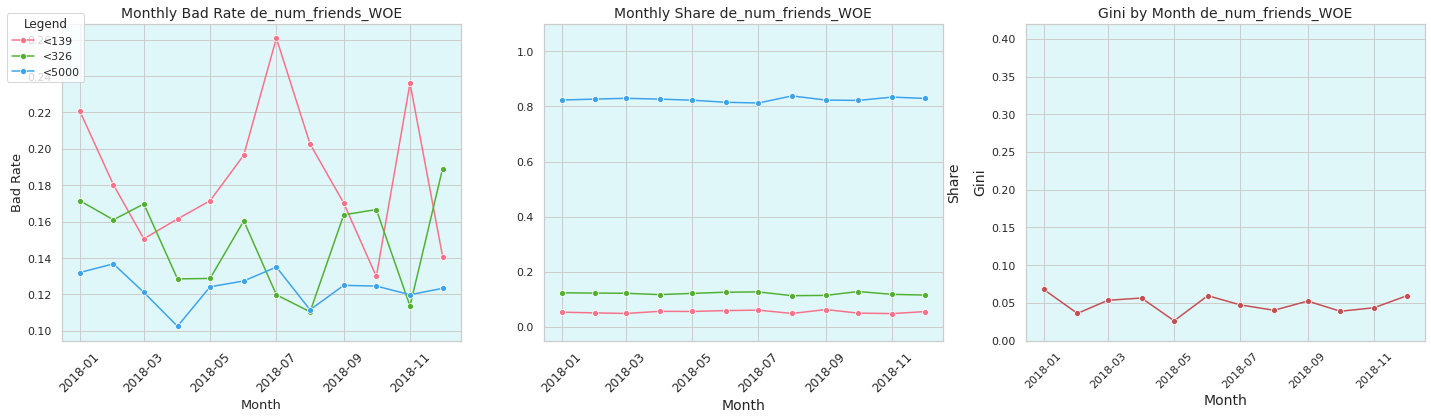

de_education_WOE


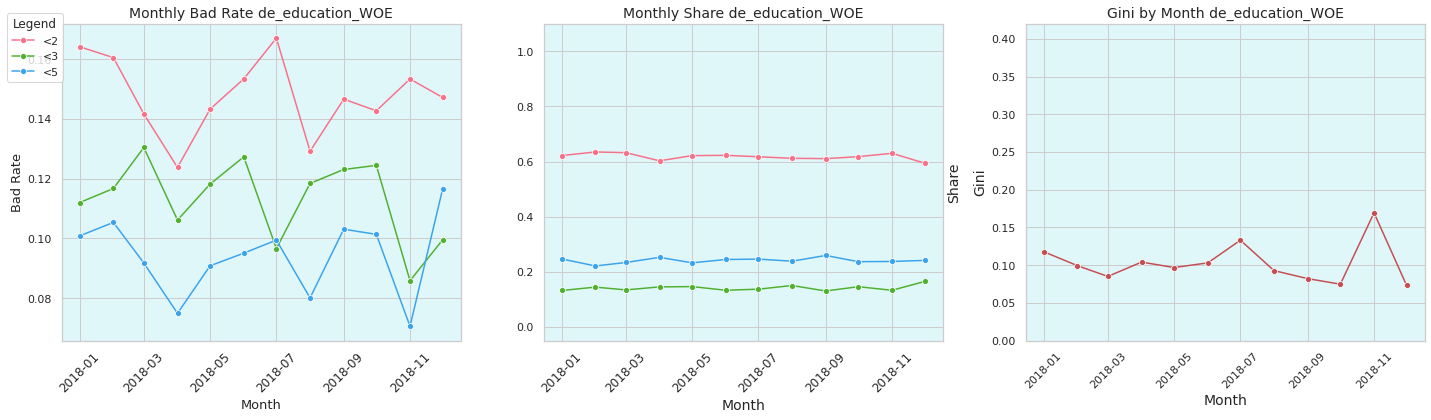

r_salary_cnt_children_WOE


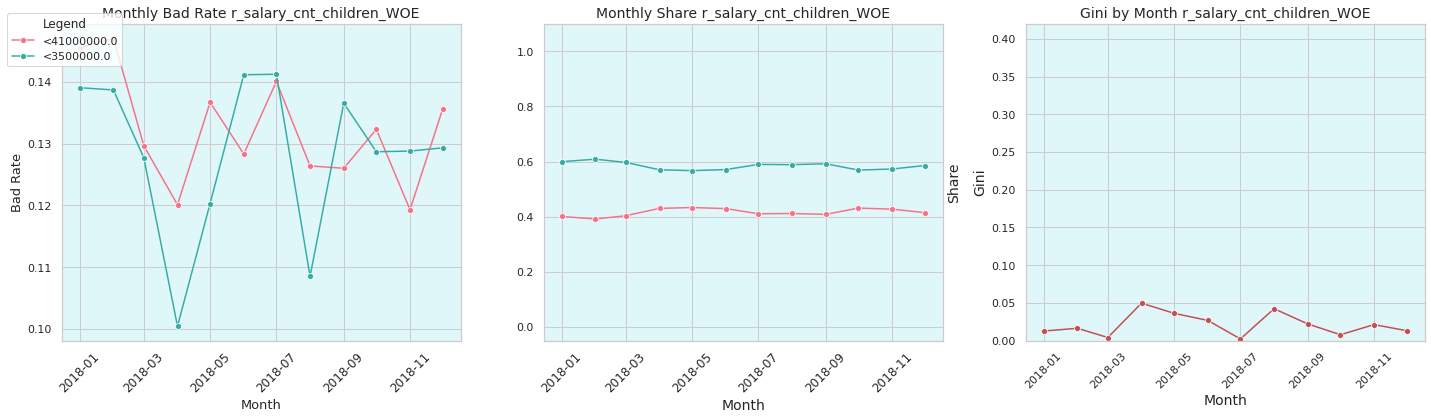

ph_other_device_info_upd_WOE


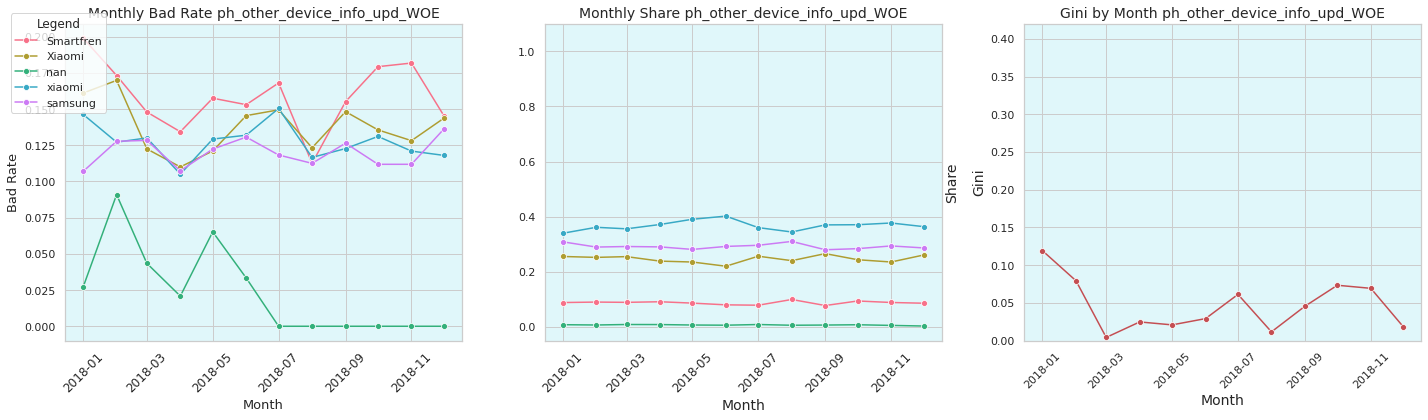

de_employment_duration_WOE


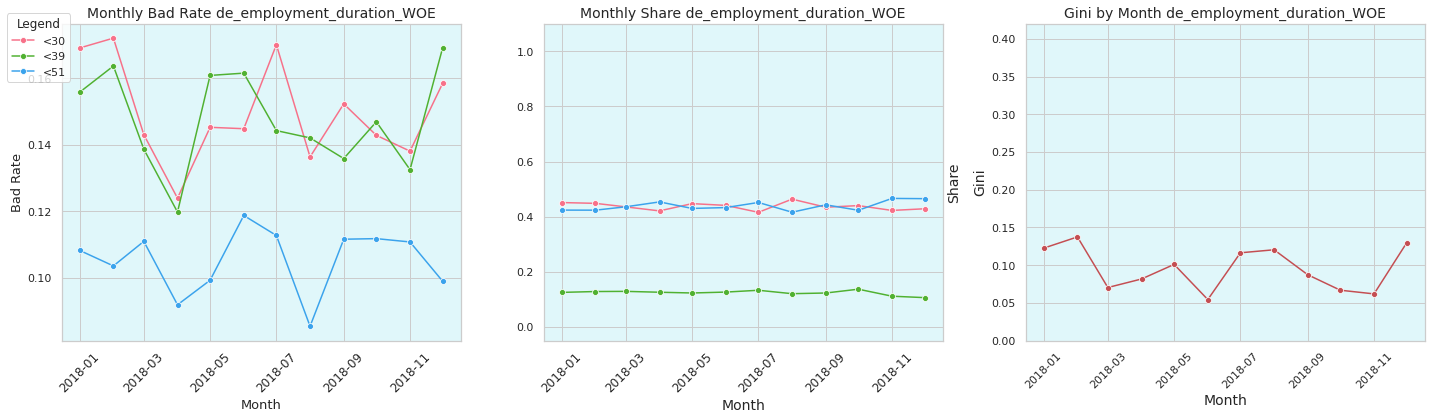

In [860]:

for cols in cols_grouping:
    print(cols)
    plotting_grouping(cols,data,col_target,col_id)
# cols=cols_shortlist[1]
# plotting_grouping(cols,data,col_target,col_id)

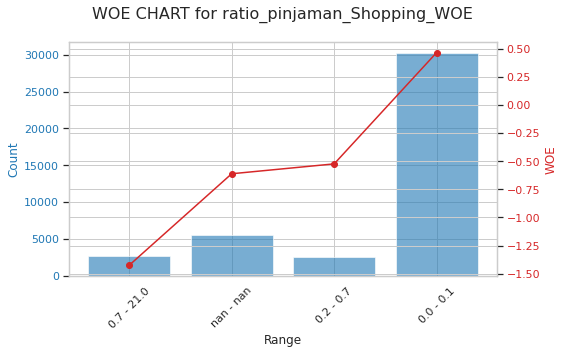

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
0.7 - 21.0,-1.426067,2683,0.7,21.0,0.381662,0.406991,ratio_pinjaman_Shopping_WOE
nan - nan,-0.610888,5483,NaN,NaN,0.227430,0.406991,ratio_pinjaman_Shopping_WOE
0.2 - 0.7,-0.522907,2627,0.2,0.7,0.198706,0.406991,ratio_pinjaman_Shopping_WOE
0.0 - 0.1,0.468844,30229,0.0,0.1,0.083595,0.406991,ratio_pinjaman_Shopping_WOE


 Informative values for the ratio_pinjaman_Shopping_WOE : 0.40699074514320954


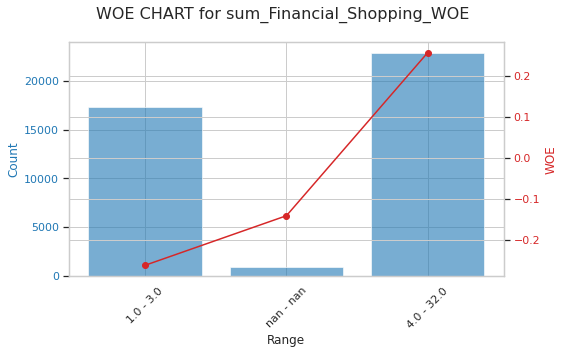

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
1.0 - 3.0,-0.262501,17268,1.0,3.0,0.167709,0.045609,sum_Financial_Shopping_WOE
nan - nan,-0.141637,913,NaN,NaN,0.113910,0.045609,sum_Financial_Shopping_WOE
4.0 - 32.0,0.256420,22841,4.0,32.0,0.101572,0.045609,sum_Financial_Shopping_WOE


 Informative values for the sum_Financial_Shopping_WOE : 0.04560893422283423


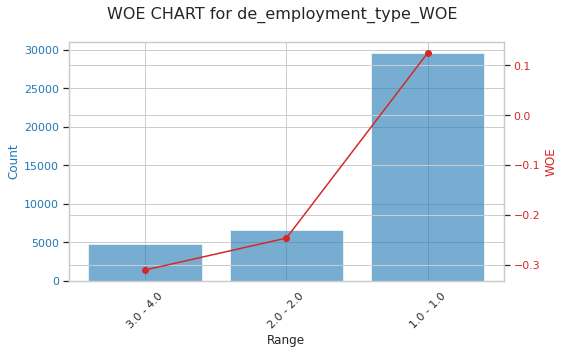

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
3.0 - 4.0,-0.309921,4835,3,4,0.161117,0.029722,de_employment_type_WOE
2.0 - 2.0,-0.245974,6621,2,2,0.157227,0.029722,de_employment_type_WOE
1.0 - 1.0,0.125291,29566,1,1,0.118379,0.029722,de_employment_type_WOE


 Informative values for the de_employment_type_WOE : 0.029721530856929457


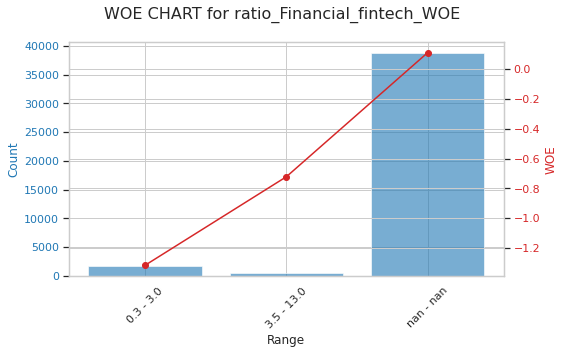

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
0.3 - 3.0,-1.317630,1737,0.3,3.0,0.357513,0.308058,ratio_Financial_fintech_WOE
3.5 - 13.0,-0.722256,543,3.5,13.0,0.298343,0.308058,ratio_Financial_fintech_WOE
nan - nan,0.112431,38742,NaN,NaN,0.117108,0.308058,ratio_Financial_fintech_WOE


 Informative values for the ratio_Financial_fintech_WOE : 0.3080578702708978


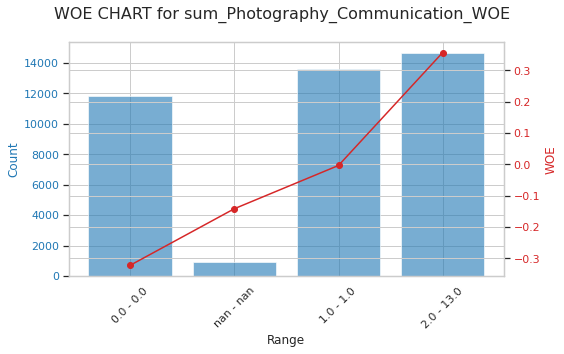

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
0.0 - 0.0,-0.322082,11815,0.0,0.0,0.176978,0.058015,sum_Photography_Communication_WOE
nan - nan,-0.141637,913,NaN,NaN,0.113910,0.058015,sum_Photography_Communication_WOE
1.0 - 1.0,-0.003599,13637,1.0,1.0,0.128327,0.058015,sum_Photography_Communication_WOE
2.0 - 13.0,0.356670,14657,2.0,13.0,0.093812,0.058015,sum_Photography_Communication_WOE


 Informative values for the sum_Photography_Communication_WOE : 0.058015224758287375


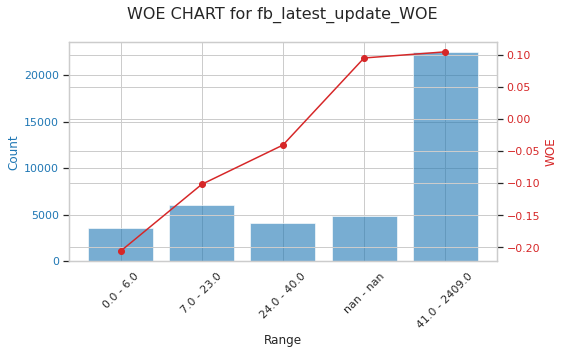

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
0.0 - 6.0,-0.205709,3609,0.0,6.0,0.167359,0.017188,fb_latest_update_WOE
7.0 - 23.0,-0.101812,6063,7.0,23.0,0.142999,0.017188,fb_latest_update_WOE
24.0 - 40.0,-0.040773,4106,24.0,40.0,0.138334,0.017188,fb_latest_update_WOE
nan - nan,0.094672,4797,NaN,NaN,0.119033,0.017188,fb_latest_update_WOE
41.0 - 2409.0,0.104203,22447,41.0,2409.0,0.120729,0.017188,fb_latest_update_WOE


 Informative values for the fb_latest_update_WOE : 0.017187623098388713


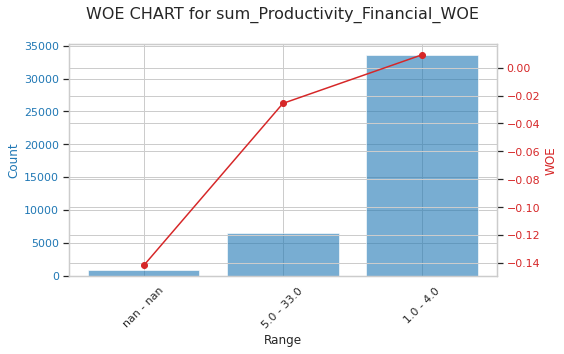

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
nan - nan,-0.141637,913,NaN,NaN,0.113910,-0.00476,sum_Productivity_Financial_WOE
5.0 - 33.0,-0.025593,6576,5.0,33.0,0.140207,-0.00476,sum_Productivity_Financial_WOE
1.0 - 4.0,0.009209,33533,1.0,4.0,0.128053,-0.00476,sum_Productivity_Financial_WOE


 Informative values for the sum_Productivity_Financial_WOE : -0.004759806555090922


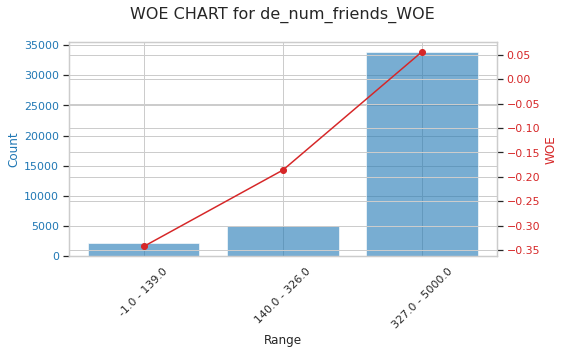

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
-1.0 - 139.0,-0.342522,2223,-1,139,0.181736,0.029992,de_num_friends_WOE
140.0 - 326.0,-0.186126,4981,140,326,0.149769,0.029992,de_num_friends_WOE
327.0 - 5000.0,0.056311,33818,327,5000,0.123307,0.029992,de_num_friends_WOE


 Informative values for the de_num_friends_WOE : 0.02999215833252012


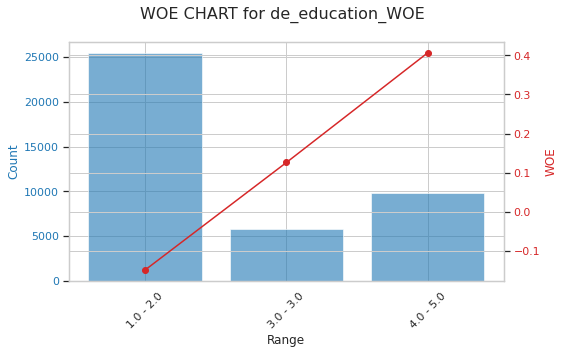

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
1.0 - 2.0,-0.149126,25445,1,2,0.147023,0.048032,de_education_WOE
3.0 - 3.0,0.125856,5758,3,3,0.116013,0.048032,de_education_WOE
4.0 - 5.0,0.406543,9819,4,5,0.092779,0.048032,de_education_WOE


 Informative values for the de_education_WOE : 0.04803160919499669


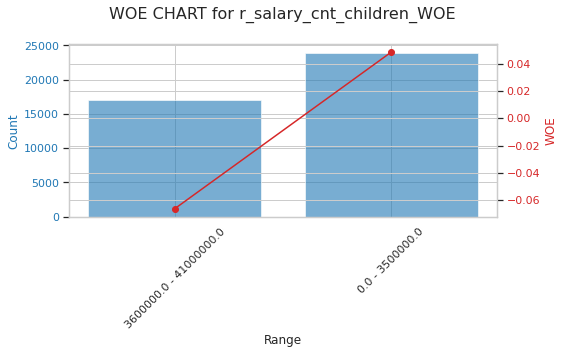

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
3600000.0 - 41000000.0,-0.066355,17079,3600000.0,41000000.0,0.133029,0.001451,r_salary_cnt_children_WOE
0.0 - 3500000.0,0.048434,23943,0.0,3500000.0,0.127302,0.001451,r_salary_cnt_children_WOE


 Informative values for the r_salary_cnt_children_WOE : 0.0014514371650326723


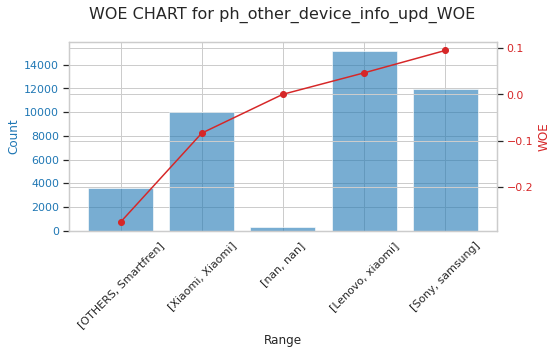

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
"[OTHERS, Smartfren]",-0.275516,3588,OTHERS,Smartfren,0.158863,0.024615,ph_other_device_info_upd_WOE
"[Xiaomi, Xiaomi]",-0.083784,10008,Xiaomi,Xiaomi,0.136890,0.024615,ph_other_device_info_upd_WOE
"[nan, nan]",0.000000,296,nan,nan,0.037162,0.024615,ph_other_device_info_upd_WOE
"[Lenovo, xiaomi]",0.046175,15173,Lenovo,xiaomi,0.127397,0.024615,ph_other_device_info_upd_WOE
"[Sony, samsung]",0.094494,11957,Sony,samsung,0.120097,0.024615,ph_other_device_info_upd_WOE


 Informative values for the ph_other_device_info_upd_WOE : 0.024615024618734438


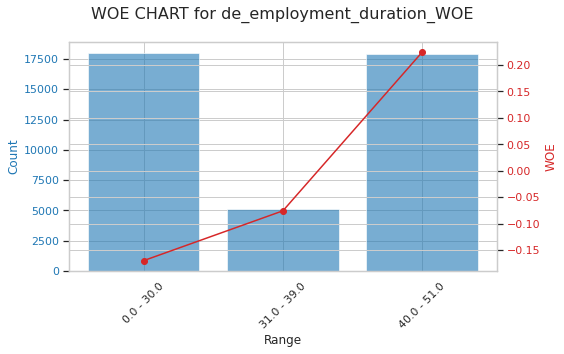

,woe,count,min,max,bad_rate,iv,pred
range,,,,,,,
0.0 - 30.0,-0.169836,18010,0,30,0.148917,0.029149,de_employment_duration_WOE
31.0 - 39.0,-0.075698,5137,31,39,0.148530,0.029149,de_employment_duration_WOE
40.0 - 51.0,0.224160,17875,40,51,0.104895,0.029149,de_employment_duration_WOE


 Informative values for the de_employment_duration_WOE : 0.029149340748775447


In [931]:
list_gg_woe=[]
for cols in cols_grouping:
    list_gg_woe.append(plotting_grouping_all(data,col_id,col_target))


In [929]:
iv_df= pd.concat(list_gg_woe,axis=0).drop_duplicates('pred')[['pred','iv']].reset_index(drop=True).set_index('pred').sort_values('iv',ascending=False)
display(iv_df)
print('the higher the Informative Value, the more predictive the model to distinct good / bad customer ')

,iv
pred,
ratio_pinjaman_Shopping_WOE,0.406991
ratio_Financial_fintech_WOE,0.308058
sum_Photography_Communication_WOE,0.058015
de_education_WOE,0.048032
sum_Financial_Shopping_WOE,0.045609
de_num_friends_WOE,0.029992
de_employment_type_WOE,0.029722
de_employment_duration_WOE,0.029149
ph_other_device_info_upd_WOE,0.024615


the higher the Informative Value, the more predictive the model to distinct good / bad customer 


# Data Splitting

In [870]:
data.groupby(['MONTH']).agg({col_id:'count',col_target:'mean'})

,index,flag_bad
MONTH,,
201801,4666,0.141663
201802,4810,0.141996
201803,5315,0.128504
201804,5712,0.108894
201805,6773,0.127418
201806,4902,0.135659
201807,1513,0.140780
201808,1519,0.115866
201809,1497,0.132265


In [871]:
development= 201805
import pandas as pd
from sklearn.model_selection import train_test_split


sample_train=data[data['MONTH']<=development].copy()
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    sample_train,  # Features (using 'id' as a feature in this example)
    sample_train[col_target],  # Target variable
    test_size=0.4,  # 30% of the data for testing
    random_state=42,  # Seed for reproducibility
    stratify=sample_train[['MONTH',col_target]]  # Stratify to ensure even distribution of target variable
)

X_train= X_train[['index']]
X_train['data_type']='train'
X_test= X_test[['index']]
X_test['data_type']='valid'
oot_set= data[data['MONTH']>development].copy()[['index']]
oot_set['data_type']='oot'

data= pd.merge(data,pd.concat([X_train,X_test,oot_set],axis=0),on='index',how='left')
# oot will use after this period 

In [883]:
col_datatype='data_type'
train_mask = (data['data_type'] == 'train') & (data[col_base] == 1) 
valid_mask = (data['data_type'] == 'valid') & (data[col_base] == 1) 
# test_mask = (data['data_type'] == 'test') & (data[col_base] == 1) 
oot_mask = (data['data_type'] == 'oot') & (data[col_base] == 1)
hoot_mask = (data['data_type'] == 'hoot') & (data[col_base] == 1)
observable_mask = data[col_base] == 1
everything_mask = pd.notnull(data[col_datatype])

In [1037]:
print('training set : ',data[train_mask].shape[0], ' rows')
print('validation set : ',data[valid_mask].shape[0], ' rows')
print('OOT set : ',data[oot_mask].shape[0], ' rows')

training set :  16365  rows
validation set :  10911  rows
OOT set :  13746  rows


## Monthly  Bad rate

In [872]:
data.groupby(['appl_month','data_type']).agg({col_id:'count',col_target:'mean'})

index  flag_bad
appl_month data_type                 
2018-01-01 train       2799  0.141479
           valid       1867  0.141939
2018-02-01 train       2886  0.142065
           valid       1924  0.141892
2018-03-01 train       3189  0.128567
           valid       2126  0.128410
2018-04-01 train       3427  0.108842
           valid       2285  0.108972
2018-05-01 train       4064  0.127461
           valid       2709  0.127353
2018-06-01 oot         4902  0.135659
2018-07-01 oot         1513  0.140780
2018-08-01 oot         1519  0.115866
2018-09-01 oot         1497  0.132265
2018-10-01 oot         1543  0.130266
2018-11-01 oot         1491  0.124748
2018-12-01 oot         1281  0.131928

# Final predictor

after apply the final proper grouping --> follow monotonicity rules, 
- higher score - higher risk
- higher score -- lower risk
- etc ( for categorical predictor)

we check the data availability by month --> the idea is whether we have certain predictor which have low hit rate

## predictor hitrate

In [899]:
cols_final=cols_grouping

### by Time

In [876]:
agg_hitrate= data[[a.replace('_WOE','') for a in cols_final]+['appl_month']].groupby(['appl_month']).count()

for cols in agg_hitrate.columns:
    agg_hitrate[cols]=(agg_hitrate[cols]/data.groupby(['appl_month'])[col_id].count()).round(3)
agg_hitrate.T*100


appl_month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
ratio_pinjaman_Shopping,83.9,86.1,85.6,87.0,87.8,88.0,86.3,86.8,87.8,87.2,88.0,86.2
sum_Financial_Shopping,97.7,97.5,97.1,97.5,98.2,98.5,97.2,98.4,98.2,97.6,97.6,98.2
de_employment_type,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
ratio_Financial_fintech,5.7,6.5,6.7,5.2,5.0,5.0,5.4,5.7,5.7,4.4,5.0,5.0
sum_Photography_Communication,97.7,97.5,97.1,97.5,98.2,98.5,97.2,98.4,98.2,97.6,97.6,98.2
fb_latest_update,77.5,80.4,85.4,89.3,95.3,89.3,94.1,92.4,93.2,91.4,91.1,99.9
sum_Productivity_Financial,97.7,97.5,97.1,97.5,98.2,98.5,97.2,98.4,98.2,97.6,97.6,98.2
de_num_friends,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
de_education,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
r_salary_cnt_children,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### by Sample Set

In [877]:
agg_hitrate= data[[a.replace('_WOE','') for a in cols_final]+['data_type']].groupby(['data_type']).count()
for cols in agg_hitrate.columns:
    agg_hitrate[cols]=(agg_hitrate[cols]/data.groupby(['data_type'])[col_id].count()).round(3)
display(agg_hitrate.T*100)


data_type,oot,train,valid
ratio_pinjaman_Shopping,87.4,86.3,86.2
sum_Financial_Shopping,98.1,97.7,97.5
de_employment_type,100.0,100.0,100.0
ratio_Financial_fintech,5.1,5.7,5.8
sum_Photography_Communication,98.1,97.7,97.5
fb_latest_update,92.0,86.7,86.1
sum_Productivity_Financial,98.1,97.7,97.5
de_num_friends,100.0,100.0,100.0
de_education,100.0,100.0,100.0
r_salary_cnt_children,100.0,100.0,100.0


## univariate Gini each predictor

### by time

In [869]:
def calculate_univariate_gini(data,cols_shortlist,col_target,set_check):


    list_all_gini=[]
    for cols in cols_shortlist:
        list_gini_calc=[]
        for month in list(data[set_check].unique()):

            gini_= (2*roc_auc_score(
            data[data[set_check]==month][col_target],
                data[data[set_check]==month][cols]*-1
            )-1)
            list_gini_calc.append(gini_)
        gini_each= pd.DataFrame({

            set_check:list(data[set_check].unique()),
            cols:list_gini_calc
        }).set_index(set_check).sort_index().T
        list_all_gini.append(gini_each)
    final_df=pd.concat(list_all_gini,axis=0).round(4)
    return final_df


In [878]:
gini_monthly= calculate_univariate_gini(data,cols_shortlist,col_target,'appl_month')
gini_monthly

appl_month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
ratio_pinjaman_Shopping_WOE,0.3042,0.3212,0.3469,0.3154,0.3050,0.3279,0.3803,0.3349,0.2928,0.3619,0.2968,0.2977
sum_Financial_Shopping_WOE,0.1580,0.1312,0.1526,0.1150,0.1280,0.1633,0.1857,0.1399,0.1236,0.1281,0.1785,0.1334
de_employment_type_WOE,0.1044,0.0500,0.0683,0.0704,0.0723,0.0913,0.0826,0.0844,0.0235,0.0669,0.0684,0.0499
ratio_Financial_fintech_WOE,0.1135,0.1202,0.0998,0.1262,0.0787,0.1110,0.0687,0.1399,0.1027,0.0989,0.1087,0.0921
sum_Photography_Communication_WOE,0.1437,0.1269,0.1532,0.1785,0.1620,0.1687,0.1737,0.1527,0.1669,0.1369,0.2021,0.1396
fb_latest_update_WOE,0.0778,0.0565,0.0911,0.0907,0.0630,0.1015,0.0134,0.0056,-0.0087,-0.0297,-0.0282,-0.0009
sum_Productivity_Financial_WOE,-0.0204,0.0107,0.0114,0.0068,0.0054,0.0428,0.0240,0.0436,0.0317,0.0301,-0.0099,0.0069
de_num_friends_WOE,0.0679,0.0361,0.0535,0.0565,0.0263,0.0596,0.0473,0.0403,0.0525,0.0390,0.0436,0.0594
de_education_WOE,0.1179,0.0994,0.0851,0.1041,0.0969,0.1031,0.1331,0.0928,0.0822,0.0748,0.1694,0.0732
r_salary_cnt_children_WOE,0.0127,0.0164,0.0042,0.0497,0.0362,-0.0268,-0.0023,0.0423,-0.0222,0.0079,-0.0213,0.0133


### by sample set

In [879]:
gini_bysample= calculate_univariate_gini(data,cols_shortlist,col_target,'data_type')
gini_bysample

data_type,oot,train,valid
ratio_pinjaman_Shopping_WOE,0.3285,0.3197,0.3167
sum_Financial_Shopping_WOE,0.1536,0.1329,0.1454
de_employment_type_WOE,0.0732,0.0692,0.0778
ratio_Financial_fintech_WOE,0.1046,0.1020,0.1123
sum_Photography_Communication_WOE,0.1649,0.1504,0.1589
fb_latest_update_WOE,0.0328,0.0662,0.0916
sum_Productivity_Financial_WOE,0.0292,-0.0002,0.0047
de_num_friends_WOE,0.0520,0.0374,0.0605
de_education_WOE,0.1043,0.1091,0.0892
r_salary_cnt_children_WOE,-0.0083,0.0197,0.0276


# model building

In [810]:
from ===library_modelling=== import GiniStepwiseLogit

cols_shortlist=['ratio_pinjaman_Shopping_WOE',
 'sum_Financial_Shopping_WOE',
 'de_employment_type_WOE',
 'ratio_Financial_fintech_WOE',
 'sum_Photography_Communication_WOE',
 'fb_latest_update_WOE',
 'sum_Productivity_Financial_WOE',
 'de_num_friends_WOE',
 'de_education_WOE',
 'r_salary_cnt_children_WOE',
 'ph_other_device_info_upd_WOE',
 'de_employment_duration_WOE']

modelSW = GiniStepwiseLogit(
    initial_predictors=[],
    max_iter=1000,
    min_increase=0.1,
    max_decrease=0.05,
    max_predictors=0,
    max_correlation=0.4,
    beta_sgn_criterion=False,
    penalty="l2",
    C=10e10,
    correlation_sample=10000,
    selection_method="forward",
    use_cv=False,
    cv_folds=5,
    cv_seed=98765,
    n_jobs=2,
)

modelSW.fit(
    data[train_mask][cols_shortlist],
    data[train_mask][col_target],
    data[valid_mask][cols_shortlist],
    data[valid_mask][col_target],
)

Regression will be trained using training sample, Gini will be evaluated using validation sample.
Iteration  0

Iter    Gini    GiniΔ  #Pred   AddedPred                                RemovedPred
[ 0]    0.00              0    []
[ 1]   31.67   +31.67     1    ratio_pinjaman_Shopping_WOE              
[ 2]   39.62    +7.95     2    sum_Financial_Shopping_WOE               
[ 3]   41.73    +2.11     3    de_employment_type_WOE                   
[ 4]   43.39    +1.66     4    ratio_Financial_fintech_WOE              
[ 5]   44.50    +1.11     5    sum_Photography_Communication_WOE        
[ 6]   45.28    +0.78     6    fb_latest_update_WOE                     
[ 7]   45.95    +0.67     7    sum_Productivity_Financial_WOE           
[ 8]   46.50    +0.55     8    de_num_friends_WOE                       
[ 9]   46.80    +0.30     9    de_education_WOE                         
[10]   47.16    +0.37    10    r_salary_cnt_children_WOE                
[11]   47.40    +0.23    11    ph_other_

In [5]:
with open('model_LR.pkl', 'rb') as file:
    modelSW = pickle.load(file)

In [1048]:
beta_coef= pd.DataFrame({
    'predictors':modelSW.predictors,
    'beta_coef':   modelSW.coef_[0]
}).set_index('predictors')
beta_coef

,beta_coef
predictors,
ratio_pinjaman_Shopping_WOE,-0.964102
sum_Financial_Shopping_WOE,-0.754413
de_employment_type_WOE,-0.807104
ratio_Financial_fintech_WOE,-0.671673
sum_Photography_Communication_WOE,-0.646221
fb_latest_update_WOE,-0.916220
sum_Productivity_Financial_WOE,5.355938
de_num_friends_WOE,-0.760202
de_education_WOE,-0.895583


## calculate each predictor marginal contribution 

In [814]:
cols_final=modelSW.predictors

In [817]:

# cols= [cols_shortlist[0]]

list_mc_df=[]
for cols in cols_final:
    cols_check= [a for a in cols_final if a not in cols]
    model = GiniStepwiseLogit(
        initial_predictors=cols_check,
        max_iter=1000,
        min_increase=0.1,
        max_decrease=0.05,
        max_predictors=0,
        max_correlation=0.3,
        beta_sgn_criterion=False,
        penalty="l2",
        C=10e10,
        correlation_sample=10000,
        selection_method="forward",
        use_cv=False,
        cv_folds=5,
        cv_seed=98765,
        n_jobs=2,
    )

    model.fit(
        data[train_mask][cols_check],
        data[train_mask][col_target],
        data[valid_mask][cols_check],
        data[valid_mask][col_target],
    )

    y_pred = model.final_model_.predict_proba(data[valid_mask][cols_check])[:, 1]
    y_pred_base = modelSW.final_model_.predict_proba(data[valid_mask][cols_final])[:, 1]

    # Calculate Gini
    gini = calculate_gini(data[valid_mask][col_target], y_pred)
    gini_base = calculate_gini(data[valid_mask][col_target], y_pred_base)



    # Store the result
    gini_mc= pd.DataFrame({
        'predictor_removed': [cols],
        'gini': [gini],
        'gini_base':[gini_base]
    })
    gini_mc['diff']=(gini_mc['gini']-gini_mc['gini_base'])*100
    list_mc_df.append(gini_mc)
list_mc_df= pd.concat(list_mc_df,axis=0)
list_mc_df.sort_values('diff')

Regression will be trained using training sample, Gini will be evaluated using validation sample.
Iteration  0

Iter    Gini    GiniΔ  #Pred   AddedPred                                RemovedPred
[ 0]   35.83              11   ['sum_Financial_Shopping_WOE', 'de_employment_type_WOE', 'ratio_Financial_fintech_WOE', 'sum_Photography_Communication_WOE', 'fb_latest_update_WOE', 'sum_Productivity_Financial_WOE', 'de_num_friends_WOE', 'de_education_WOE', 'r_salary_cnt_children_WOE', 'ph_other_device_info_upd_WOE', 'de_employment_duration_WOE']
[ 1]   35.83    +0.00    11                                             
Regression will be trained using training sample, Gini will be evaluated using validation sample.
Iteration  0

Iter    Gini    GiniΔ  #Pred   AddedPred                                RemovedPred
[ 0]   45.93              11   ['ratio_pinjaman_Shopping_WOE', 'de_employment_type_WOE', 'ratio_Financial_fintech_WOE', 'sum_Photography_Communication_WOE', 'fb_latest_update_WOE', 'sum_Pr

,predictor_removed,gini,gini_base,diff
0,ratio_pinjaman_Shopping_WOE,0.358349,0.475762,-11.741301
0,sum_Financial_Shopping_WOE,0.459271,0.475762,-1.649050
0,ratio_Financial_fintech_WOE,0.459472,0.475762,-1.629007
0,de_employment_type_WOE,0.462807,0.475762,-1.295537
0,fb_latest_update_WOE,0.468880,0.475762,-0.688181
0,sum_Productivity_Financial_WOE,0.469010,0.475762,-0.675206
0,de_num_friends_WOE,0.469293,0.475762,-0.646889
0,de_education_WOE,0.471514,0.475762,-0.424778
0,sum_Photography_Communication_WOE,0.471814,0.475762,-0.394791
0,r_salary_cnt_children_WOE,0.471898,0.475762,-0.386383


In [884]:
(list_mc_df.sort_values('diff',ascending=False)).round(3).reset_index(drop=True)

,predictor_removed,gini,gini_base,diff
0,de_employment_duration_WOE,0.474,0.476,-0.179
1,ph_other_device_info_upd_WOE,0.473,0.476,-0.314
2,r_salary_cnt_children_WOE,0.472,0.476,-0.386
3,sum_Photography_Communication_WOE,0.472,0.476,-0.395
4,de_education_WOE,0.472,0.476,-0.425
5,de_num_friends_WOE,0.469,0.476,-0.647
6,sum_Productivity_Financial_WOE,0.469,0.476,-0.675
7,fb_latest_update_WOE,0.469,0.476,-0.688
8,de_employment_type_WOE,0.463,0.476,-1.296
9,ratio_Financial_fintech_WOE,0.459,0.476,-1.629


## check correlation 

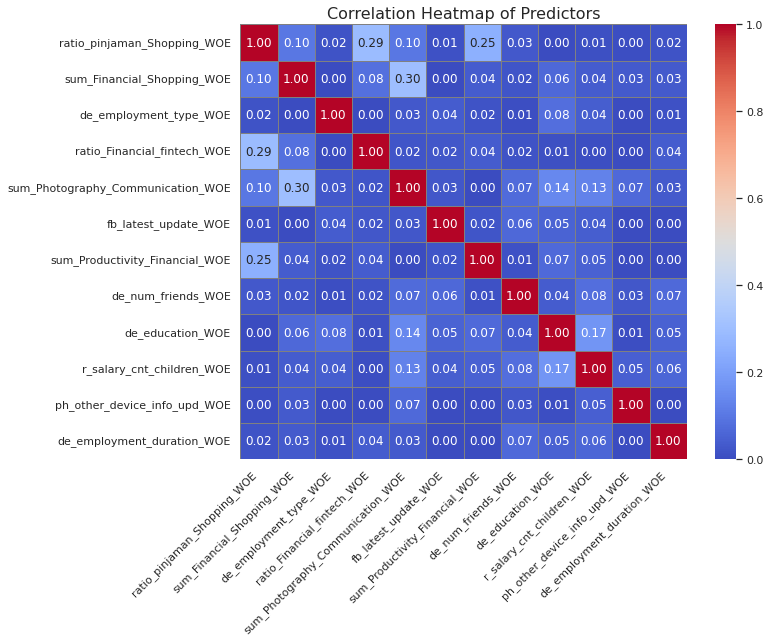

In [1075]:
corr_matrix= data[modelSW.predictors].corr().abs()
# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                      linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
# Customize the plot
heatmap.set_title('Correlation Heatmap of Predictors', size=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.yticks(rotation=0) 
plt.show()


# model performance

In [998]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gini_and_bad_rate(monthly_data):
    # Ensure 'month' is a datetime column or a string that represents months
    if not pd.api.types.is_datetime64_any_dtype(monthly_data['appl_month']):
        monthly_data['appl_month'] = pd.to_datetime(monthly_data['appl_month'], format='%Y-%m')

    # Sort data by month
    monthly_data = monthly_data.sort_values(by='appl_month')
    
    # Calculate the bad rate if not directly available
    # Assuming 'flag_bad' is already a proportion, otherwise, compute it
    monthly_data['bad_rate'] = monthly_data['flag_bad']  # Replace with actual bad rate calculation if necessary

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Gini on the primary y-axis
    ax1.set_xlabel('appl_month')
    ax1.set_ylabel('Gini Coefficient (%)', color='tab:blue')
    ax1.plot(monthly_data['appl_month'], monthly_data['gini_month'], color='tab:blue', marker='o', label='Gini Coefficient')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0,70)

    # Create a secondary y-axis for the bad rate
    ax2 = ax1.twinx()
    ax2.set_ylabel('Bad Rate', color='tab:red')
    ax2.plot(monthly_data['appl_month'], monthly_data['bad_rate'], color='tab:red', marker='s', linestyle='--', label='Bad Rate')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0,30)
    
    # Add a title and grid
    plt.title('Gini Coefficient and Bad Rate by Month')
    ax1.grid(True)

    # Show plot
    plt.show()





In [950]:
def calculate_ks_statistic(data, col_score, col_target,data_type):
    list_ks=[]
    for type_ in list(data[data_type].unique()):
        data_each=data[data[data_type]==type_]
        # Sort by score in descending order
        data_sorted = data_each.sort_values(by=col_score, ascending=False)

        # Compute cumulative distributions for each class
        total_pos = data_sorted[col_target].sum()
        total_neg = len(data_sorted) - total_pos

        # Cumulative positive and negative rates
        data_sorted['cumulative_pos'] = data_sorted[col_target].cumsum() / total_pos
        data_sorted['cumulative_neg'] = (1 - data_sorted[col_target]).cumsum() / total_neg

        # Calculate the KS statistic
        data_sorted['ks'] = data_sorted['cumulative_pos'] - data_sorted['cumulative_neg']
        ks_statistic = data_sorted['ks'].max()
        list_ks.append(ks_statistic)
    df_ks= pd.DataFrame({
        
        data_type:list(data[data_type].unique()),
        'KS':list_ks
    })
    
    return df_ks



In [973]:

from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc_curve(data_train, data_valid, data_test, col_score, col_target):
    # Prepare data
    y_true_train = data_train[col_target]
    y_score_train = data_train[col_score]
    
    y_true_valid = data_valid[col_target]
    y_score_valid = data_valid[col_score]
    
    y_true_test = data_test[col_target]
    y_score_test = data_test[col_score]
    
    # Calculate ROC curve and AUC for train, valid, and test sets
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_score_train)
    auc_train = roc_auc_score(y_true_train, y_score_train)
    
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_score_valid)
    auc_valid = roc_auc_score(y_true_valid, y_score_valid)
    
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_score_test)
    auc_test = roc_auc_score(y_true_test, y_score_test)
    
    # Plot ROC curve
    plt.figure(figsize=(7, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, label=f'Validation ROC curve (area = {auc_valid:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'OOT ROC curve (area = {auc_test:.2f})')
    
    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    
    # Customize plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Show plot
    plt.show()


# plot_roc_auc_curve(data_train, data_valid, 'score', 'target')


## model scoring

In [819]:
col_score='gm_modelling_v1'
data[col_score]=modelSW.final_model_.predict_proba(data[cols_final])[:, 1]

##  performance by sample set

In [820]:
gini_by_sample=( calculate_univariate_gini(
    data,
    [col_score],
    col_target,'data_type')*-1).T
ks_statistic = calculate_ks_statistic(data, col_score, col_target,'data_type')


,gm_modelling_v1,KS
data_type,,
oot,0.4786,0.363047
train,0.4816,0.360887
valid,0.4758,0.363423


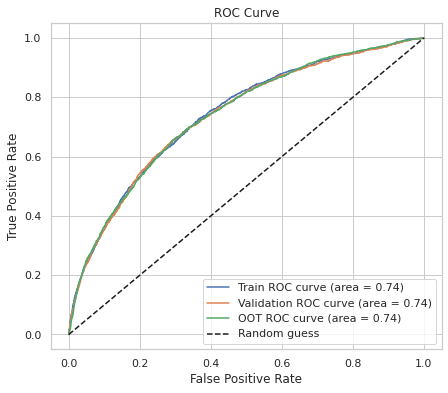

In [978]:
display(pd.concat([gini_by_sample,ks_statistic.set_index('data_type')],axis=1))
plot_roc_auc_curve(data[train_mask], data[valid_mask],data[oot_mask], col_score, col_target)


## by Time 

In [964]:
gini_by_time= calculate_univariate_gini(
    data[data['data_type']!='train'],
    [col_score],
    col_target,'appl_month')*-1
gini_by_time= gini_by_time.T
ks_month= calculate_ks_statistic(data, col_score, col_target,'appl_month')

In [1000]:
monthly_perf= pd.concat([gini_by_time,ks_month.set_index('appl_month')],axis=1)
monthly_perf

,gm_modelling_v1,KS
appl_month,,
2018-01-01,0.5023,0.372496
2018-02-01,0.5134,0.393077
2018-03-01,0.4166,0.375089
2018-04-01,0.4931,0.359370
2018-05-01,0.4528,0.331171
2018-06-01,0.4723,0.365859
2018-07-01,0.5417,0.453005
2018-08-01,0.4926,0.379624
2018-09-01,0.4407,0.346619


In [986]:
monthly_data= pd.concat([monthly_perf.rename(columns= {col_score:'gini_month'}),
data.groupby(['appl_month']).agg({col_score:'mean',col_target:'mean'}).rename(columns= {col_score:'avg_score'})],axis=1)

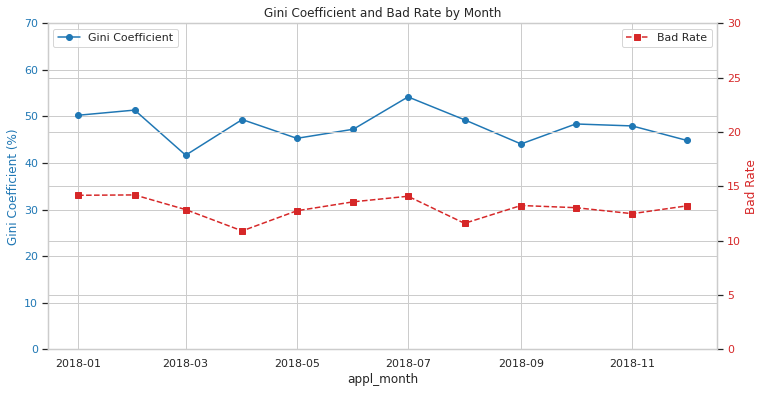

In [1001]:
plot_gini_and_bad_rate((monthly_data[['gini_month','flag_bad']]*100).reset_index())

## monotonicity 

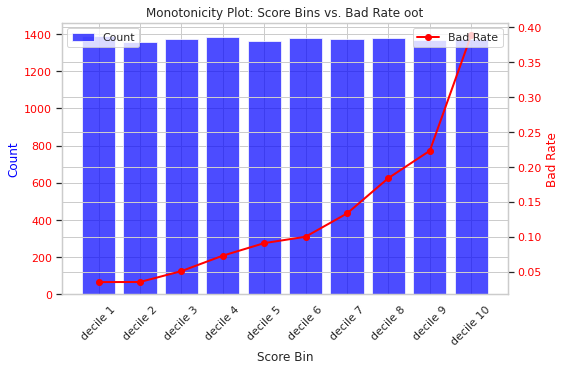

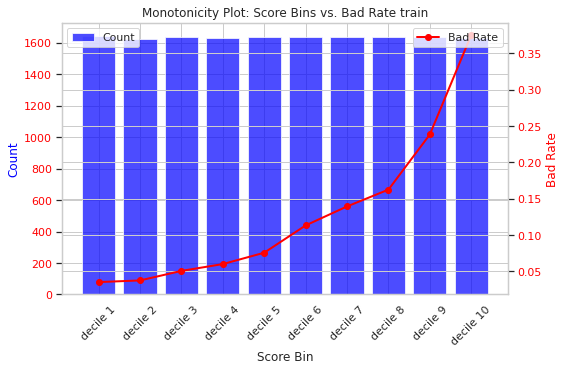

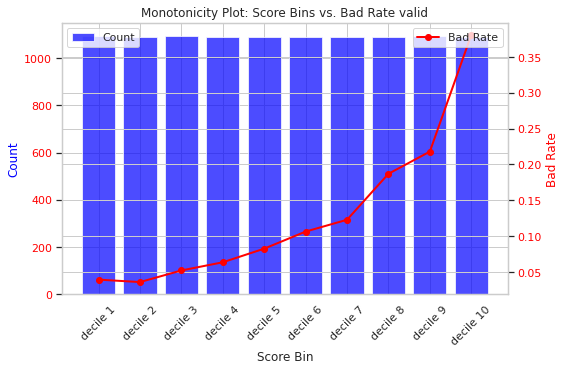

In [1011]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_monotonicity(data, col_score, col_target,data_type):
    
    data['bin'] = pd.qcut(data[col_score], q=10, labels=False)
    
    # Calculate statistics for each bin
    binned_data = data.groupby('bin').agg(
        count=(col_target, 'size'),
        bad_rate=(col_target, 'mean')
    ).reset_index()
    
    # Create plot
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    # Plot bar chart for counts
    ax1.bar(binned_data['bin'], binned_data['count'], color='blue', alpha=0.7, label='Count')
    ax1.set_xlabel('Score Bin')
    ax1.set_ylabel('Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Create secondary y-axis for bad rate
    ax2 = ax1.twinx()
    ax2.plot(binned_data['bin'], binned_data['bad_rate'], color='red', marker='o', linestyle='-', linewidth=2, label='Bad Rate')
    ax2.set_ylabel('Bad Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add title and legend
    plt.title(f'Monotonicity Plot: Score Bins vs. Bad Rate {data_type}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    bin_labels = [f'decile {i+1}' for i in range(10)]  # Labels for 10 bins
    ax1.set_xticks(binned_data['bin'])
    ax1.set_xticklabels(bin_labels, rotation=45)
    
    # Show plot
    plt.show()

for type_ in list(data['data_type'].unique()):
    each_df=data[data['data_type']==type_]
    plot_monotonicity(each_df, col_score, col_target,type_)


In [1021]:
df_bin= data[[col_score,col_target,data_type,'appl_month']]
df_bin= df_bin.sort_values(col_score).reset_index()
df_bin['bin']=pd.qcut(df_bin[col_score],q=10)
agg_bin= df_bin.groupby(['bin']).agg({col_id:'count',col_score:'mean',col_target:['sum','mean']})
agg_bin.columns= ['count','avg_score','bad_cnt','bad_rate']
agg_bin

,count,avg_score,bad_cnt,bad_rate
bin,,,,
"(0.0148, 0.0388]",4103,0.030700,145.0,0.035340
"(0.0388, 0.0504]",4102,0.044839,153.0,0.037299
"(0.0504, 0.0623]",4161,0.056493,221.0,0.053112
"(0.0623, 0.0743]",4050,0.068331,258.0,0.063704
"(0.0743, 0.0885]",4095,0.081305,344.0,0.084005
"(0.0885, 0.107]",4102,0.096969,424.0,0.103364
"(0.107, 0.132]",4113,0.118542,563.0,0.136883
"(0.132, 0.175]",4092,0.151650,708.0,0.173021
"(0.175, 0.27]",4101,0.215596,942.0,0.229700


## LIFT  & Gain Chart

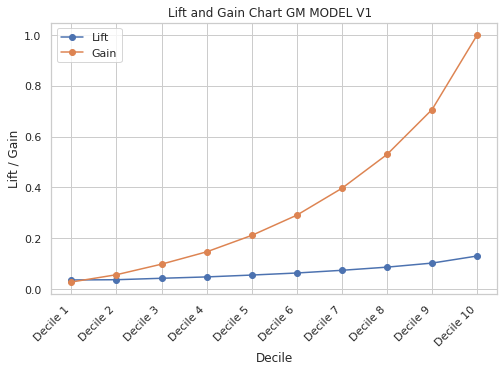

In [1085]:
def lift_gain_chart(y_true, y_scores, bins=10):
    data = pd.DataFrame({'true': y_true, 'score': y_scores})
    data['bin'] = pd.qcut(data['score'], q=bins, labels=False)
    grouped = data.groupby('bin').agg({'true': ['sum', 'count']})
    grouped.columns = ['positive', 'total']
    grouped['cumulative_positive'] = grouped['positive'].cumsum()
    grouped['cumulative_total'] = grouped['total'].cumsum()
    grouped['lift'] = grouped['cumulative_positive'] / grouped['cumulative_total']
    grouped['gain'] = grouped['cumulative_positive'] / grouped['positive'].sum()
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    plt.plot(grouped.index, grouped['lift'], marker='o', label='Lift')
    plt.plot(grouped.index, grouped['gain'], marker='o', label='Gain')
    bin_labels = [f'Decile {i+1}' for i in range(bins)]  # Labels for 10 bins (1 to 10)
    ax1.set_xticks(range(bins))
    ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
#     ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
    plt.xlabel('Decile')
    plt.ylabel('Lift / Gain')
    plt.title('Lift and Gain Chart GM MODEL V1  ')
    plt.legend()
    plt.show()

lift_gain_chart(data[col_target], data[col_score],bins=10)

## calibration curve

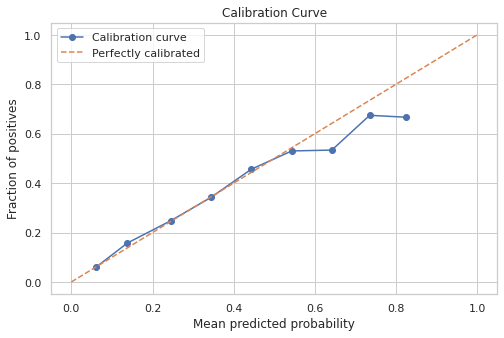

In [1079]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(data[col_target], data[col_score], n_bins=10)

fig, ax1 = plt.subplots(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


# production implementation 

In [1069]:
cols=cols_grouping[0]
list_implementation= []
for cols in cols_grouping:
    cols_raw=cols.replace('_WOE','')
    agg_each= data.groupby([cols]).agg({col_id:'count',cols_raw:['min','max',],col_target:['count','sum','mean']}).reset_index()
    agg_each.columns= ['woe','count','min','max','obs','bad','bad_rate']
    agg_each['pred']=cols_raw
    agg_each['beta']=beta_coef.loc[cols].values[0].round(4)
    agg_each['IV']=iv_df.loc[cols].values[0].round(4)
    agg_each= agg_each[['pred','count','min','max','beta','obs','bad','bad_rate','woe','IV']]
    list_implementation.append(agg_each)
    
list_implementation= pd.concat(list_implementation,axis=0).reset_index(drop=True)
list_implementation

,pred,count,min,max,beta,obs,bad,bad_rate,woe,IV
0,ratio_pinjaman_Shopping,2683,0.714286,21.0,-0.9641,2683,1024.0,0.381662,-1.426067,0.4070
1,ratio_pinjaman_Shopping,5483,NaN,NaN,-0.9641,5483,1247.0,0.227430,-0.610888,0.4070
2,ratio_pinjaman_Shopping,2627,0.166667,0.666667,-0.9641,2627,522.0,0.198706,-0.522907,0.4070
3,ratio_pinjaman_Shopping,30229,0.0,0.142857,-0.9641,30229,2527.0,0.083595,0.468844,0.4070
4,sum_Financial_Shopping,17268,1.0,3.0,-0.7544,17268,2896.0,0.167709,-0.262501,0.0456
5,sum_Financial_Shopping,913,NaN,NaN,-0.7544,913,104.0,0.113910,-0.141637,0.0456
6,sum_Financial_Shopping,22841,4.0,32.0,-0.7544,22841,2320.0,0.101572,0.256420,0.0456
7,de_employment_type,4835,3,4,-0.8071,4835,779.0,0.161117,-0.309921,0.0297
8,de_employment_type,6621,2,2,-0.8071,6621,1041.0,0.157227,-0.245974,0.0297
9,de_employment_type,29566,1,1,-0.8071,29566,3500.0,0.118379,0.125291,0.0297


checking stability 